In [166]:
import sys, ftplib, os, requests, iris, metpy.calc,time
from metpy.units import units
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("/Users/jago/Downloads")
import netCDF4 as nc
from datetime import datetime,timedelta
import scipy.interpolate
import numpy as np

save_dir = "data/wind/radar/capel-dewi/"
forcast_dir = "data/wind/gfs/"

radar_lat=52.42
radar_long=-4.01

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Notes
## Radar data
- Descriptor says the 7 day variability is "1.0 - 3.0 m/s for altitudes between 2 and 15 km and in the range 3.0 - 4.0 m/s between 15 and 20 km"

In [162]:
def daterange(start_date, end_date):
#https://stackoverflow.com/questions/1060279/iterating-through-a-range-of-dates-in-python
    for n in range(int((end_date - start_date).days+1)):
        yield start_date + timedelta(n)

In [163]:
start_date="20201201"
end_date="20201201"

start_dt = datetime.strptime(start_date, "%Y%m%d")
end_dt = datetime.strptime(end_date, "%Y%m%d")

uname="jagosw"
pwd="ftBr7AaY"

forcast_distance="006"

In [164]:
%time it
f=ftplib.FTP("ftp.ceda.ac.uk", uname, pwd)

for day in daterange(start_dt, end_dt):
    year = day.strftime("%Y")
    month = day.strftime("%m")
    date = day.strftime("%Y%m%d")
    file="radar-mst_capel-dewi_%s_st300_cartesian_v3.nc"%date
    
    f.cwd("/badc/mst/data/mst-products-v3/st-mode/cartesian/%s/%s"%(year, month))
    f.retrbinary("RETR %s" % file, open("%s%s.nc"%(save_dir,date), "wb").write)

In [167]:
ts=time.time()
n_measured=pd.DataFrame()
e_measured=pd.DataFrame()
for day in daterange(start_dt, end_dt):
    date = day.strftime("%Y%m%d")
    data = nc.Dataset("%s%s.nc"%(save_dir,date))
    alts=data["altitude"][:]
    for index,time in enumerate(data["time"][:]):
        n=scipy.interpolate.interp1d(data["altitude"][:],
                                     data["northward_wind"][index][:],
                                     fill_value=(data["northward_wind"][index][:][0],data["northward_wind"][index][:][-1]),
                                     bounds_error=False)
        e=scipy.interpolate.interp1d(data["altitude"][:],
                                     data["eastward_wind"][index][:],
                                     fill_value=(data["eastward_wind"][index][:][0],data["eastward_wind"][index][:][-1]),
                                     bounds_error=False)
        row_n=[]
        row_e=[]
        for a in range(0,2500):
            row_n.append(n(10*a))
            row_e.append(e(10*a))
        n_measured.insert(0,day.timestamp()+time,row_n)
        e_measured.insert(0,day.timestamp()+time,row_e)
print(time.time()-ts)

AttributeError: 'numpy.float32' object has no attribute 'time'

In [91]:
interps=[]
for a in range(0,2500):
    interps.append(scipy.interpolate.interp1d(n_measured.columns.values.tolist(),n_measured.loc[a].to_list(),fill_value="extrapolate"))

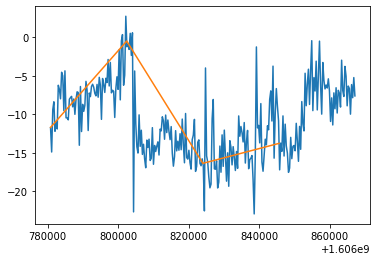

In [92]:
plt.plot(n_df.columns.values.tolist(),n_df.loc[1].to_list())
plt.plot([start_dt.timestamp(),start_dt.timestamp()+6*60*60,start_dt.timestamp()+12*60*60,start_dt.timestamp()+18*60*60],[interps[1](start_dt.timestamp()),interps[1](start_dt.timestamp()+6*60*60),interps[1](start_dt.timestamp()+12*60*60),interps[1](start_dt.timestamp()+18*60*60)])

In [99]:
for day in daterange(start_dt, end_dt):
    ym=day.strftime("%Y%m")
    date=day.strftime("%Y%m%d")
    #this url will only work as far back as 18th May 2020
    url="https://www.ncei.noaa.gov/data/global-forecast-system/access/grid-004-0.5-degree/forecast/%s/%s/gfs_4_%s_0000_%s.grb2"%(ym,date,date,forcast_distance)
    r = requests.get(url, stream=True)
    with open("%s%s.grb2"%(forcast_dir, date),'wb') as f:
        for chunk in r.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)

In [127]:
#x wind is 168, y wind 180 and geopotential 122
for day in daterange(start_dt, end_dt):
    date=day.strftime("%Y%m%d")
    data=iris.load("%s%s.grb2"%(forcast_dir, date))
    data_x=data[168]
    data_y=data[180]
    data_geo=data[122]

In [158]:
sample_point=[('latitude', radar_lat),
              ('longitude', radar_long)]
w_x=data_x.interpolate(sample_point, iris.analysis.Linear())#Should change wind to use this shite
w_y=data_y.interpolate(sample_point, iris.analysis.Linear())
geo=data_geo.interpolate(sample_point, iris.analysis.Linear())

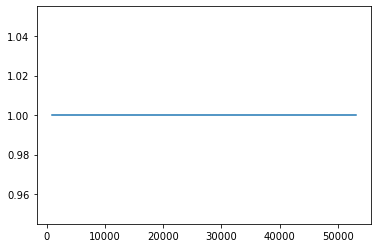

In [159]:
x=[]
y=[]
for n in range(0,31):
    x.append(geo[n].data)
    y.append(10*metpy.calc.geopotential_to_height(geo[n].data*units.m**2/units.s**2).magnitude)
plt.plot(x,[a/y[i] for i,a in enumerate(y)])

In [160]:
geo.data

array([53128.971664  , 46342.5804    , 41131.036272  , 38213.872804  ,
       34739.00602   , 32571.313392  , 30334.201164  , 27825.766196  ,
       26053.179184  , 23549.711104  , 21778.155784  , 20408.984372  ,
       18346.770546  , 16160.761466  , 13670.757452  , 11926.529894  ,
       10532.5854    ,  9333.593467  ,  8274.34692   ,  7323.316572  ,
        6462.099053  ,  5678.348382  ,  4958.2906605 ,  4290.5504228 ,
        3668.2093316 ,  3085.9681968 ,  2539.3226148 ,  2024.742698  ,
        1539.2412145 ,  1079.870408  ,   859.21252337,   643.59324292,
         432.27801725,   225.36853955])